# Hand Gesture Detector

This is an example of multi-class classification using CNN.
Data in csv format: https://www.kaggle.com/datasets/datamunge/sign-language-mnist

Keras Functional API and functions are used to build the simple CNN

In [1]:
import math
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from keras import regularizers,optimizers
from tensorflow.keras.utils import to_categorical
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl

%matplotlib inline


### Function to load the data
It is usually better to define a dataloader function that can be reused with similar format of data. In this case data is in csv format.
Normalization of the images is done in this dataloader. And, the data that is stored in csv file in 1D vector is reshaped into a 2D image to be used in CNN.

In [2]:
def load_dataset(path_to_train = '/Data\HandGesture/sign_train.csv', path_to_test = '/Data\HandGesture/sign_test.csv'):
    train_df = pd.read_csv(os.getcwd() + path_to_train)
    test_df = pd.read_csv(os.getcwd() + path_to_test)
    
    train_data = np.array(train_df, dtype = 'float32')
    test_data = np.array(test_df, dtype = 'float32')
    
    #Normalize right here
    train_x = train_data[:, 1:] / 255 
    test_x = test_data[:, 1:] / 255
    train_x = train_x.reshape(-1, 28, 28, 1)
    test_x = test_x.reshape(-1, 28, 28, 1)
    
    train_y = train_data[:, 0]
    test_y = test_data[:, 0]
    
    classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 
                   'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y' ]
    
    return train_x, train_y, test_x, test_y, classes

### Loadin the data
Data is loaded using the define fuction. Path can be given to the location of the file.

It is always good to check the # of trainings and test. 

The Y labels both in train and test data are given as a number. To be able to train the model and be compatible with loss functions, they are translate into one_hot vectors using the to_categorical.

🛎️ 🛎️ 🛎️ It is also always good idea to check the # of trainings in each class for categorical classification problems. But to keep this notebook short, this has been skipped as this dataset has almost a uniform distribution and high number of training examples in each class. 

In [10]:
X_train, Y_train, X_test, Y_test, classes = load_dataset()
Y_train_cat = to_categorical(Y_train, num_classes = 25)
Y_test_cat = to_categorical(Y_test, num_classes = 25)

print ("# trainings = " + str(X_train.shape[0]))
print ("# tests  = " + str(X_test.shape[0]))

# trainings = 27455
# tests  = 7172


### Data Inspection
Usually we must check the shape of the data that is loaded and inspect/visualize some of them together with their labels

X_train shape: (27455, 28, 28, 1)
Y_train_cat shape: (27455, 25)
X_test shape: (7172, 28, 28, 1)
Y_test_cat shape: (7172, 25)


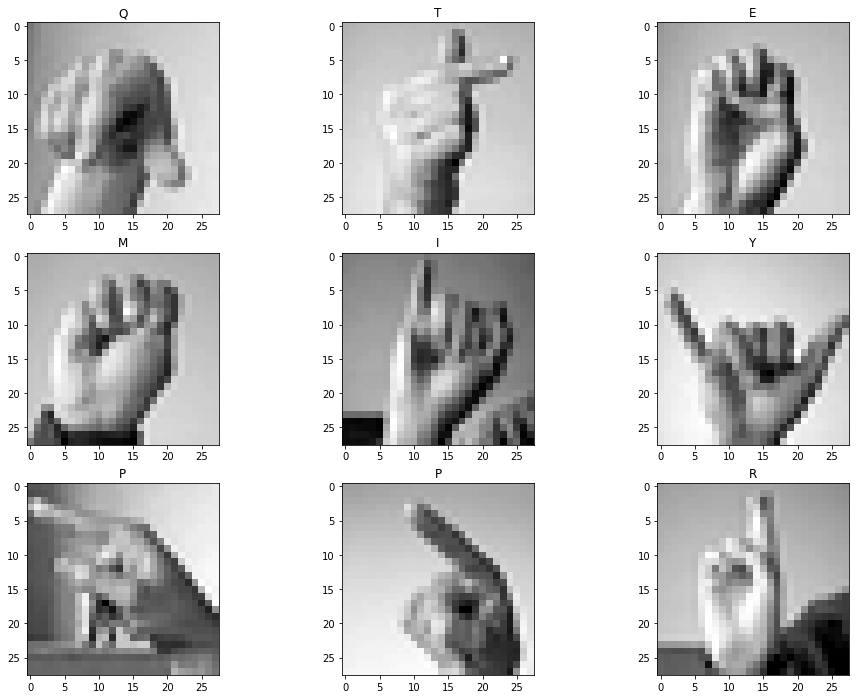

In [11]:
print ("X_train shape: " + str(X_train.shape))
print ("Y_train_cat shape: " + str(Y_train_cat.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test_cat shape: " + str(Y_test_cat.shape))

fig, ax = plt.subplots(3, 3, figsize=(16, 12))
for i in range(9):
    r = random.randint(0, X_train.shape[0])
    ax[i // 3, i % 3].imshow(X_train[r], cmap = 'gray')
    label = classes[int(Y_train[r])]
    ax[i // 3, i % 3].set_title(label)

## Building the model using Tensorflow Keras

Different models can be experimented. What is used here as an example is:
 - Conv2D, 32 x (3 x 3), same padding, and ReLu activation
 - MaxPooling, default (2 x 2) 
 - Dropout. 
 
 - Conv2D, 64 x (3 x 3), same padding, and ReLu activation
 - MaxPooling, default (2 x 2) 
 - Dropout. 
 
 - Conv2D, 128 x (3 x 3), same padding, and ReLu activation
 - MaxPooling, default (2 x 2) 
 - Dropout. 
 
 - Flatten - results is 2 x 2 x 128 = 512 size layer
 - Dense - with the number of classes and softmax
  

In [6]:
def Model(input_shape):
    
    input_image = tf.keras.Input(shape=input_shape)
    A1 = tfl.Conv2D(32, kernel_size = (3,3), padding="same", activation = 'relu')(input_image)
    P1 = tfl.MaxPool2D()(A1)
    D1 = tfl.Dropout(0.2)(P1)
    
    A2 = tfl.Conv2D(64, kernel_size = (3,3), activation = 'relu')(D1)
    P2 = tfl.MaxPool2D()(A2)
    D2 = tfl.Dropout(0.2)(P2)
    
    A3 = tfl.Conv2D(128, kernel_size = (3,3), activation = 'relu')(D2)
    P3 = tfl.MaxPool2D()(A3)
    D3 = tfl.Dropout(0.2)(P3)
    
    F = tfl.Flatten()(D3)
    outputs = tfl.Dense(25, activation="softmax")(F)
    
    # YOUR CODE ENDS HERE
    model = tf.keras.Model(inputs=input_image, outputs=outputs)
    return model

### Checking the model summary to see if it makes sense

In [7]:
SignMode = Model(X_train.shape[1:])

SignMode.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                         

## Train the model
Using ADAM optimizer and categorical cross-entropy loss.
We keep track of the model history and send the validation data to record validation accuracy at each epoch

In [8]:
SignMode.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

train_data = tf.data.Dataset.from_tensor_slices((X_train, Y_train_cat)).batch(64)
test_data = tf.data.Dataset.from_tensor_slices((X_test, Y_test_cat)).batch(64)

model_history = SignMode.fit(train_data, epochs = 20, validation_data=test_data)

Epoch 1/20
429/429 [==============================] - 7s 16ms/step - loss: 1.7003 - accuracy: 0.4801 - val_loss: 0.6061 - val_accuracy: 0.8020
Epoch 2/20
429/429 [==============================] - 7s 16ms/step - loss: 0.3512 - accuracy: 0.8832 - val_loss: 0.2888 - val_accuracy: 0.8954
Epoch 3/20
429/429 [==============================] - 7s 16ms/step - loss: 0.1524 - accuracy: 0.9498 - val_loss: 0.2059 - val_accuracy: 0.9350
Epoch 4/20
429/429 [==============================] - 7s 16ms/step - loss: 0.0914 - accuracy: 0.9711 - val_loss: 0.1903 - val_accuracy: 0.9377
Epoch 5/20
429/429 [==============================] - 7s 16ms/step - loss: 0.0592 - accuracy: 0.9816 - val_loss: 0.1903 - val_accuracy: 0.9356
Epoch 6/20
429/429 [==============================] - 7s 16ms/step - loss: 0.0403 - accuracy: 0.9878 - val_loss: 0.1812 - val_accuracy: 0.9453
Epoch 7/20
429/429 [==============================] - 7s 16ms/step - loss: 0.0327 - accuracy: 0.9905 - val_loss: 0.2043 - val_accuracy: 0.9417

## Visualize the model performance
Plotting the accuracy and loss for both training and test data vs. epochs

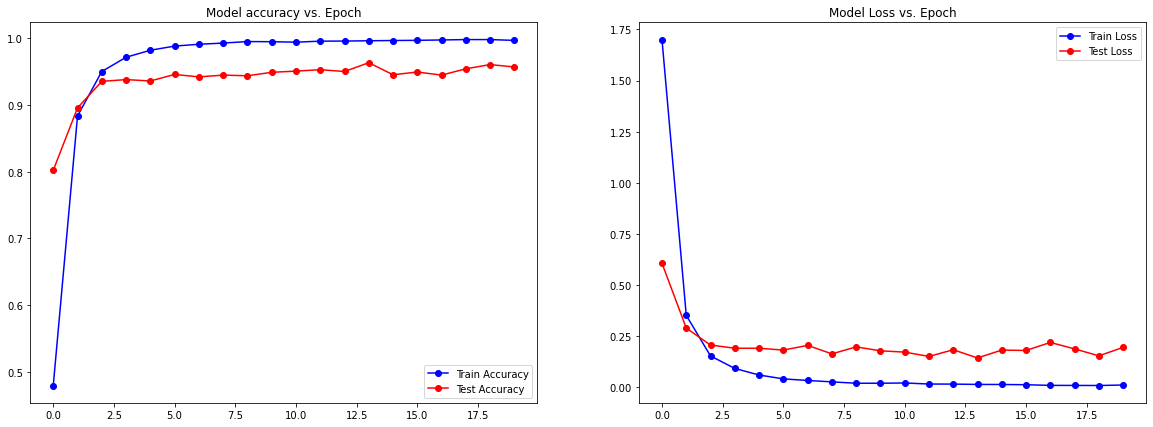

In [13]:
epochs = [i for i in range(20)]
train_accuracy = model_history.history['accuracy']
train_loss = model_history.history['loss']
validation_accuracy = model_history.history['val_accuracy']
validation_loss = model_history.history['val_loss']

fig, ax = plt.subplots(1, 2, figsize=(20, 7))
ax[0].plot(epochs, train_accuracy,  'bo-', label = 'Train Accuracy')
ax[0].plot(epochs, validation_accuracy,  'ro-', label = 'Test Accuracy')
ax[0].set_title('Model accuracy vs. Epoch')
ax[0].legend()


ax[1].plot(epochs, train_loss,  'bo-', label = 'Train Loss')
ax[1].plot(epochs, validation_loss,  'ro-', label = 'Test Loss')
ax[1].set_title('Model Loss vs. Epoch')
ax[1].legend()

## Other notes:

- It is possible to improve the performance by adding an additional dense layer at the end. Skipped here to improve the speed.
- In multi-call problems, it is good practice to plot and inspect a confusion matrix, to check how many of true labels are called and where the errors are. In this notebook, I skipped this to make it shorter for now, but may add here later or have another notebook to show the concept.
- Inspecting the test data available, that is in principle our dev data, it seems that it comes from the same distribution of the training. So the model performance could be worse in case of real-life data input to it. To improve this data-augmentation techniques can be use, like rotating the input images, and adding them as training or test and check the results.
- On my system, training took 1 min for 50 epochs and resulted in 96% accuracy on test data

